In [1]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

import torch
from torch import *
dataset_x = torch.load("/kaggle/input/zip-40k-dataset-cxr/final_x/final_x.pt")
dataset_y = torch.load("/kaggle/input/zip-40k-dataset-cxr/final_y (1).pt")

In [3]:
from sklearn.model_selection import train_test_split
xtr, xts, ytr, yts = train_test_split(dataset_x, dataset_y, test_size=0.2, shuffle=True, stratify=dataset_y)

In [4]:
xtr.size()

torch.Size([32301, 1, 224, 224])

In [5]:
xts.size()

torch.Size([8076, 1, 224, 224])

In [6]:
import torch
from torch import *
my_dataset = torch.utils.data.TensorDataset(xtr,ytr) # create your datset
my_dataloader = torch.utils.data.DataLoader(my_dataset,batch_size=32,
                                          shuffle=True, num_workers=2)

my_dataset = torch.utils.data.TensorDataset(xts,yts) # create your datset
my_tdataloader = torch.utils.data.DataLoader(my_dataset,batch_size=32)

In [7]:
len(my_dataloader)

1010

In [8]:
from IPython.display import clear_output

In [9]:
rep = []

In [10]:
feature_vec=[]

In [11]:
import os
import time
from tempfile import TemporaryDirectory

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

import torch
import torchvision.models as models


if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    device = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    device = torch.device('cpu')



import timm

CUDA is available. Working on GPU


# Model Densenet201

In [12]:
# from timm
pretrained_model_name = 'densenet201'
model_d201 = timm.create_model(pretrained_model_name, pretrained=True)

num_channels = 1  # for grayscale images, but it could be any number
# Extract the first conv layer's parameters
num_filters = model_d201.features.conv0.out_channels
kernel_size = model_d201.features.conv0.kernel_size
stride = model_d201.features.conv0.stride
padding = model_d201.features.conv0.padding
conv1 = torch.nn.Conv2d(num_channels, num_filters, kernel_size=kernel_size, stride=stride, padding=padding)
original_weights = model_d201.features.conv0.weight.data.mean(dim=1, keepdim=True)
conv1.weight.data = original_weights.repeat(1, num_channels, 1, 1)
model_d201.features.conv0 = conv1

# Freeze only the convolutional layers of the pre-trained model
for param in model_d201.parameters():
    if isinstance(param, nn.Conv2d):
        param.requires_grad = False



# Modify the model head for fine-tuning
num_features = 2048

# Additional linear layer and dropout layer
model_d201.fc = nn.Sequential(
    nn.Linear(num_features, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function (you can choose other activation functions too)
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, 4)
)

#model_d201 = torch.nn.DataParallel(model_d201, device_ids = [0,1]).to(device)


model.safetensors:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

# model InceptionV3

In [13]:


# from timm
pretrained_model_name = "inception_v3"
model_inv3 = timm.create_model(pretrained_model_name, pretrained=True)
#print(model)
num_channels = 1  # for grayscale images, but it could be any number
# Extract the first conv layer's parameters
num_filters = model_inv3.Conv2d_1a_3x3.conv.out_channels
kernel_size = model_inv3.Conv2d_1a_3x3.conv.kernel_size
stride = model_inv3.Conv2d_1a_3x3.conv.stride
padding = model_inv3.Conv2d_1a_3x3.conv.padding
conv1 = torch.nn.Conv2d(num_channels, num_filters, kernel_size=kernel_size, stride=stride, padding=padding)
original_weights = model_inv3.Conv2d_1a_3x3.conv.weight.data.mean(dim=1, keepdim=True)
conv1.weight.data = original_weights.repeat(1, num_channels, 1, 1)
model_inv3.Conv2d_1a_3x3.conv = conv1

# Freeze only the convolutional layers of the pre-trained model
for param in model_inv3.parameters():
    if isinstance(param, nn.Conv2d):
        param.requires_grad = False



# Modify the model head for fine-tuning
num_features = 2048

# Additional linear layer and dropout layer
model_inv3.fc = nn.Sequential(
    nn.Linear(num_features, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function (you can choose other activation functions too)
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, 4)
)

#model_inv3 = torch.nn.DataParallel(model_inv3, device_ids = [0,1]).to(device)



model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

In [14]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        
        self.classifier = nn.Linear(1004, 4)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        x.size()
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_inv3, model_d201)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = torch.nn.DataParallel(ensemble_model, device_ids = [0,1]).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(ensemble_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training

In [16]:
rep = []

In [17]:

batch_size=32
num_epochs=30
val_size = len(my_tdataloader)
train_size = len(my_dataloader) 

losses = [] 
accuracies = [] 
val_losses = [] 
val_accuracies = [] 
# Train the model 
cnt = 0
x = range(0,num_epochs)
for epoch in x: 
    cnt = 0
    for i, (images, labels) in enumerate(my_dataloader): 
        # Forward pass 
        images=images.to(device) 
        labels=labels.type(torch.LongTensor).to(device) 
        outputs = ensemble_model(images) 
        loss = criterion(outputs, labels) 
        
        # Backward pass and optimization 
        optimizer_ft.zero_grad() 
        loss.backward() 
        optimizer_ft.step() 
        cnt = cnt+1
        print(cnt,end=' ')
        if cnt == 1010 :
            clear_output()
            cnt = 0
        _, predicted = torch.max(outputs.data, 1)
        
    acc = (predicted == labels).sum().item() / labels.size(0) 
    accuracies.append(acc) 
    losses.append(loss.item()) 

    # Evaluate the model on the validation set	
    rep.append('Epoch [{}/{}],Loss:{:.4f},Accuracy:{:.2f}'.format( 
        epoch+1, num_epochs, loss.item(),acc))
    print('Epoch [{}/{}],Loss:{:.4f},Accuracy:{:.2f}'.format( 
        epoch+1, num_epochs, loss.item(),acc))

Epoch [31.0/30],Loss:0.9991,Accuracy:0.46


In [18]:
import torch
torch.cuda.empty_cache()

# Evaluation

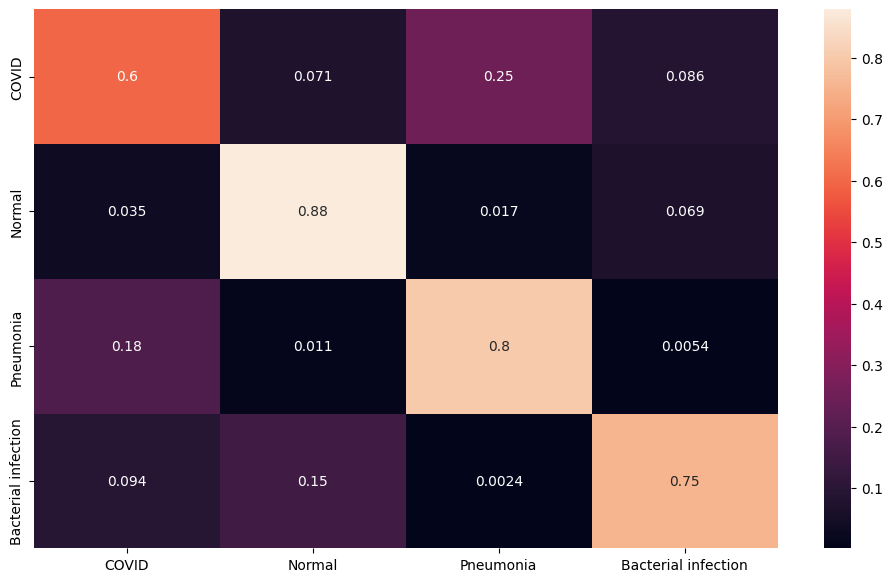

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []  

# iterate over test data
for inputs, labels in my_tdataloader:
        output = ensemble_model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('COVID','Normal','Pneumonia','Bacterial infection')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1890
           1       0.79      0.88      0.83      2039
           2       0.76      0.80      0.78      2055
           3       0.83      0.75      0.79      2092

    accuracy                           0.76      8076
   macro avg       0.76      0.76      0.76      8076
weighted avg       0.76      0.76      0.76      8076



'              precision    recall  f1-score   support\n\n           0       0.64      0.60      0.62      1890\n           1       0.79      0.88      0.83      2039\n           2       0.76      0.80      0.78      2055\n           3       0.83      0.75      0.79      2092\n\n    accuracy                           0.76      8076\n   macro avg       0.76      0.76      0.76      8076\nweighted avg       0.76      0.76      0.76      8076\n'